In [105]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from pydpmd.calc import run_binned, run_binned_ragged, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
import pandas as pd
import h5py
import pickle
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [ ]:
path = '/home/mmccraw/dev/data/10-10-25/friction-contacts-torques/run'
data = load(path, location=["final", "init"], load_trajectory=True, load_full=False)
data.calculate_mu_eff()

with h5py.File(os.path.join(path, 'trajectory.h5'), 'r') as f:
    friction_coeff = [f['ragged']['friction_coeff'][k][:] for k in sorted(list(f['ragged']['friction_coeff'].keys()))]
    pair_ids = [f['ragged']['pair_ids'][k][:] for k in sorted(list(f['ragged']['pair_ids'].keys()))]
    pair_vertex_contacts = [f['ragged']['pair_vertex_contacts'][k][:] for k in sorted(list(f['ragged']['pair_vertex_contacts'].keys()))]

# save this:
n_contacts_total = np.mean([data.trajectory[i].n_contacts_total for i in range(data.trajectory.num_frames())], axis=0)

abs_torque_hist = np.abs(np.array([data.trajectory[i].torque for i in range(data.trajectory.num_frames())]))
abs_torque_sum = np.add.reduceat(abs_torque_hist, data.system_offset[:-1], axis=1)
num_nonzero_torque = np.add.reduceat(abs_torque_hist != 0, data.system_offset[:-1], axis=1)

# save these:
abs_torque_mean_nonzero = np.mean(abs_torque_sum / num_nonzero_torque, axis=0)
abs_torque_std_nonzero = np.std(abs_torque_sum / num_nonzero_torque, axis=0)
abs_torque_mean = np.mean(abs_torque_sum / data.system_size, axis=0)
abs_torque_std = np.std(abs_torque_sum / data.system_size, axis=0)

force_norm_hist = np.linalg.norm(np.array([data.trajectory[i].force for i in range(data.trajectory.num_frames())]), axis=2)
force_norm_sum = np.add.reduceat(force_norm_hist, data.system_offset[:-1], axis=1)
num_nonzero_force = np.add.reduceat(force_norm_hist != 0, data.system_offset[:-1], axis=1)

# save these:
force_norm_mean_nonzero = np.mean(force_norm_sum / num_nonzero_force, axis=0)
force_norm_std_nonzero = np.std(force_norm_sum / num_nonzero_force, axis=0)
force_norm_mean = np.mean(force_norm_sum / data.system_size, axis=0)
force_norm_std = np.std(force_norm_sum / data.system_size, axis=0)

friction_coeff_hist = [[] for _ in range(data.n_systems())]
zv_hist = [[] for _ in range(data.n_systems())]

for fid in range(len(friction_coeff)):
    friction_coeff_frame = friction_coeff[fid]
    pair_vertex_contacts_frame = pair_vertex_contacts[fid]
    pair_ids_frame = pair_ids[fid]
    for sid in range(data.n_systems()):
        beg = data.system_offset[sid]
        end = data.system_offset[sid + 1]
        system_mask = np.all((pair_ids_frame >= beg) & (pair_ids_frame < end), axis=1)
        friction_coeff_hist[sid].extend(friction_coeff_frame[system_mask])
        zv_hist[sid].append(pair_vertex_contacts_frame[system_mask])
friction_coeff_hist = [np.array(f) for f in friction_coeff_hist]
zv_hist = [np.concatenate(f) for f in zv_hist]

pair_type_count_hist = []
pair_type_friction_hist = []

for z, mu in zip(zv_hist, friction_coeff_hist):
    total_counts = z[np.all(z != 0, axis=1)].shape[0]
    pair_types = np.sort(np.unique(z[np.all(z != 0, axis=1)], axis=0), axis=1)
    unique_pairs, inverse_ids = np.unique(pair_types, axis=0, return_inverse=True)
    pair_to_id_map = {tuple(pair): idx for idx, pair in enumerate(unique_pairs)}

    count_map = {}
    friction_map = {}
    for pair, idx in pair_to_id_map.items():
        count_map[idx] = np.all(z == pair, axis=1).sum()
        friction_map[idx] = np.mean(mu[np.all(z == pair, axis=1)])

    pair_type_count_hist.append({i_j: count_map[idx] / total_counts for i_j, idx in pair_to_id_map.items()})
    pair_type_friction_hist.append({i_j: friction_map[idx] for i_j, idx in pair_to_id_map.items()})

with open(os.path.join(path, 'friction_contacts_torques.pkl'), 'wb') as f:
    pickle.dump({
        'friction_coeff_hist': [mu[mu > 0] for mu in friction_coeff_hist],
        'pair_type_count_hist': pair_type_count_hist,
        'pair_type_friction_hist': pair_type_friction_hist,
        'force_norm_nonzero': force_norm_mean_nonzero,
        'force_norm_std_nonzero': force_norm_std_nonzero,
        'force_norm': force_norm_mean,
        'force_norm_std': force_norm_std,
        'abs_torque_nonzero': abs_torque_mean_nonzero,
        'abs_torque_std_nonzero': abs_torque_std_nonzero,
        'abs_torque': abs_torque_mean,
    }, f)


/tmp/ipykernel_1646065/424956568.py:14: RuntimeWarning: invalid value encountered in divide
  abs_torque_mean_nonzero = np.mean(abs_torque_sum / num_nonzero_torque, axis=0)
/tmp/ipykernel_1646065/424956568.py:15: RuntimeWarning: invalid value encountered in divide
  abs_torque_std_nonzero = np.std(abs_torque_sum / num_nonzero_torque, axis=0)
/tmp/ipykernel_1646065/424956568.py:24: RuntimeWarning: invalid value encountered in divide
  force_norm_mean_nonzero = np.mean(force_norm_sum / num_nonzero_force, axis=0)
/tmp/ipykernel_1646065/424956568.py:25: RuntimeWarning: invalid value encountered in divide
  force_norm_std_nonzero = np.std(force_norm_sum / num_nonzero_force, axis=0)


In [104]:
[mu[mu > 0] for mu in friction_coeff_hist]

[array([0.46988001, 0.3337303 , 2.05359698, ..., 2.05155408, 1.02640223,
        0.55523016]),
 array([2.26162221, 2.04792793, 2.07303415, ..., 2.08643166, 0.41283721,
        2.40618085]),
 array([1.98399374, 2.00247389, 1.68310573, ..., 2.23094818, 0.3269176 ,
        0.3537472 ]),
 array([0.41534798, 1.59957057, 1.01497836, ..., 2.413623  , 1.40887188,
        1.95378497]),
 array([2.39111631, 0.08548118, 2.20653396, ..., 1.60225065, 0.16099413,
        2.0300964 ]),
 array([0.41891704, 2.00067423, 2.00969632, ..., 0.95758839, 2.10206503,
        2.04852405]),
 array([0.14162927, 2.00876804, 2.02888649, ..., 1.4868994 , 2.00436079,
        1.91548737]),
 array([2.00737512, 2.01711065, 0.19488536, ..., 0.49804565, 1.99377199,
        0.85022698]),
 array([2.06590808, 0.75506975, 2.00230368, ..., 2.02606105, 2.280297  ,
        2.03340948]),
 array([2.06684613, 0.14335141, 0.77336222, ..., 0.40665923, 0.25669014,
        0.33473405]),
 array([2.00345602, 2.38275154, 2.03937848, ..., 0

[array([0.46988001, 0.3337303 , 2.05359698, ..., 2.05155408, 1.02640223,
        0.55523016]),
 array([2.26162221, 2.04792793, 2.07303415, ..., 2.08643166, 0.41283721,
        2.40618085]),
 array([1.98399374, 2.00247389, 1.68310573, ..., 2.23094818, 0.3269176 ,
        0.3537472 ]),
 array([0.41534798, 1.59957057, 1.01497836, ..., 2.413623  , 1.40887188,
        1.95378497]),
 array([2.39111631, 0.08548118, 2.20653396, ..., 1.60225065, 0.16099413,
        2.0300964 ]),
 array([0.41891704, 2.00067423, 2.00969632, ..., 0.95758839, 2.10206503,
        2.04852405]),
 array([0.14162927, 2.00876804, 2.02888649, ..., 1.4868994 , 2.00436079,
        1.91548737]),
 array([2.00737512, 2.01711065, 0.19488536, ..., 0.49804565, 1.99377199,
        0.85022698]),
 array([2.06590808, 0.75506975, 2.00230368, ..., 2.02606105, 2.280297  ,
        2.03340948]),
 array([2.06684613, 0.14335141, 0.77336222, ..., 0.40665923, 0.25669014,
        0.33473405]),
 array([2.00345602, 2.38275154, 2.03937848, ..., 0

In [60]:
mus = data.mu_eff[data.system_offset[:-1]]
norm = LogNorm(vmin=min(mus), vmax=max(mus))
cmap = plt.cm.viridis

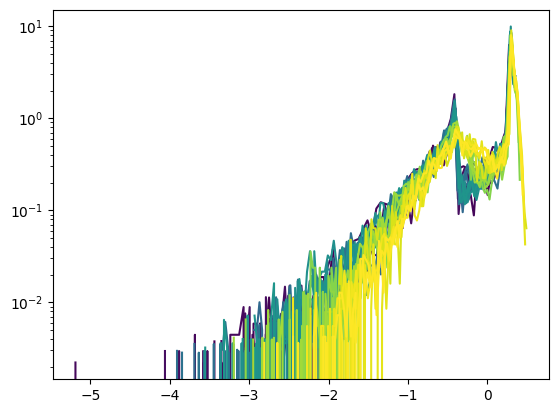

In [66]:
for sid in range(data.n_systems()):
    x = friction_coeff_hist[sid][friction_coeff_hist[sid] != 0]
    y, bins = np.histogram(np.log10(x), bins=100, density=True)
    plt.plot(bins[:-1], y, c=cmap(norm(mus[sid])))
plt.yscale('log')
# plt.xscale('log')
plt.show()

$\sigma_{xy}=\frac{1}{A} \Sigma_i m_i v_{i,x} v_{i,y} + \Sigma_j r_{ij, x} f_{ij, y} =\frac{1}{A}  \Sigma_i m_i v_{i, x} v_{i, y} + W_{i, xy}$

$G(\tau) = \frac{A}{k_B T}\langle \sigma_{xy}(t+\tau) \sigma_{xy}(t)\rangle_t=\frac{A}{k_B T}\langle (\frac{1}{A}  \Sigma_i m_i v_{i, x}(t+\tau) v_{i, y}(t+\tau) + W_{i, xy}(t+\tau)) (\frac{1}{A}  \Sigma_i' m_i' v_{i', x}(t) v_{i', y}(t) + W_{i', xy}(t)) \rangle_t$

$G(\tau) = \frac{1}{k_B T A} \langle \Sigma_i \Sigma_i' m_i v_{i, x}(t+\tau) v_{i, y}(t+\tau) m_i' v_{i', x}(t) v_{i', y}(t) + W_{i, xy}(t+\tau) W_{i', xy}(t) + m_i v_{i, x}(t+\tau) v_{i, y}(t+\tau) W_{i', xy}(t) + m_i' v_{i', x}(t) v_{i', y}(t) W_{i, xy}(t+\tau) \rangle_t$